In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from pathlib import Path

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_98018/510143023.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")

def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [3]:
gsize = {}
for p in Path("../results/truth").rglob("*.fai"):
    sample = p.parts[-2]
    size = sum(int(l.split("\t")[1]) for l in p.read_text().splitlines())
    gsize[sample] = size

In [50]:
frames = []
tsvs = list(Path("../results/benchmark/call/mutref").rglob("*.tsv"))
tsvs.extend(list(Path("../results/benchmark/align_to_mutref").rglob("*.tsv")))
for p in tsvs:
    df = pd.read_csv(p, sep="\t")
    sample = p.stem
    model = p.parts[-2].split("_")[-1].split("@")[0]
    mode = p.parts[-4]
    dp = int(p.parts[-5][:-1])
    bp = dp * gsize[sample]
    caller = p.parts[-6]

    if "align" in caller:
        caller = "align"

    df["sample"] = sample
    df["model"] = model
    df["mode"] = mode
    df["depth"] = dp
    df["caller"] = caller
    df["bp"] = bp
    # use rate which is sec/Mbp
    df["rate"] = df["cpu_time"] / df["bp"] * 1e6

    frames.append(df)

In [51]:
df = pd.concat(frames)
df.head()

,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,sample,model,mode,depth,caller,bp,rate
0,27.2634,0:00:27,2430.59,12442.39,1239.43,1443.16,135.55,1.22,147.75,44.61,AMtb_1__202402,hac,duplex,10,nanocaller,44055370,1.012589
0,20.4283,0:00:20,1999.21,11778.52,819.17,1021.98,135.87,3.26,187.94,44.34,ATCC_19119__202309,hac,duplex,10,nanocaller,29192130,1.518903
0,22.5279,0:00:22,1991.00,11561.30,796.44,999.21,136.24,2.96,145.98,39.60,BPH2947__202310,hac,duplex,10,nanocaller,30799530,1.285734
0,29.9515,0:00:29,2424.36,12368.58,1235.61,1438.62,132.41,1.57,150.68,47.30,ATCC_10708__202309,hac,duplex,10,nanocaller,48019670,0.985013
0,31.6126,0:00:31,2485.42,12434.79,1221.24,1424.30,132.45,1.93,159.21,51.22,AJ292__202310,hac,duplex,10,nanocaller,54450050,0.940679


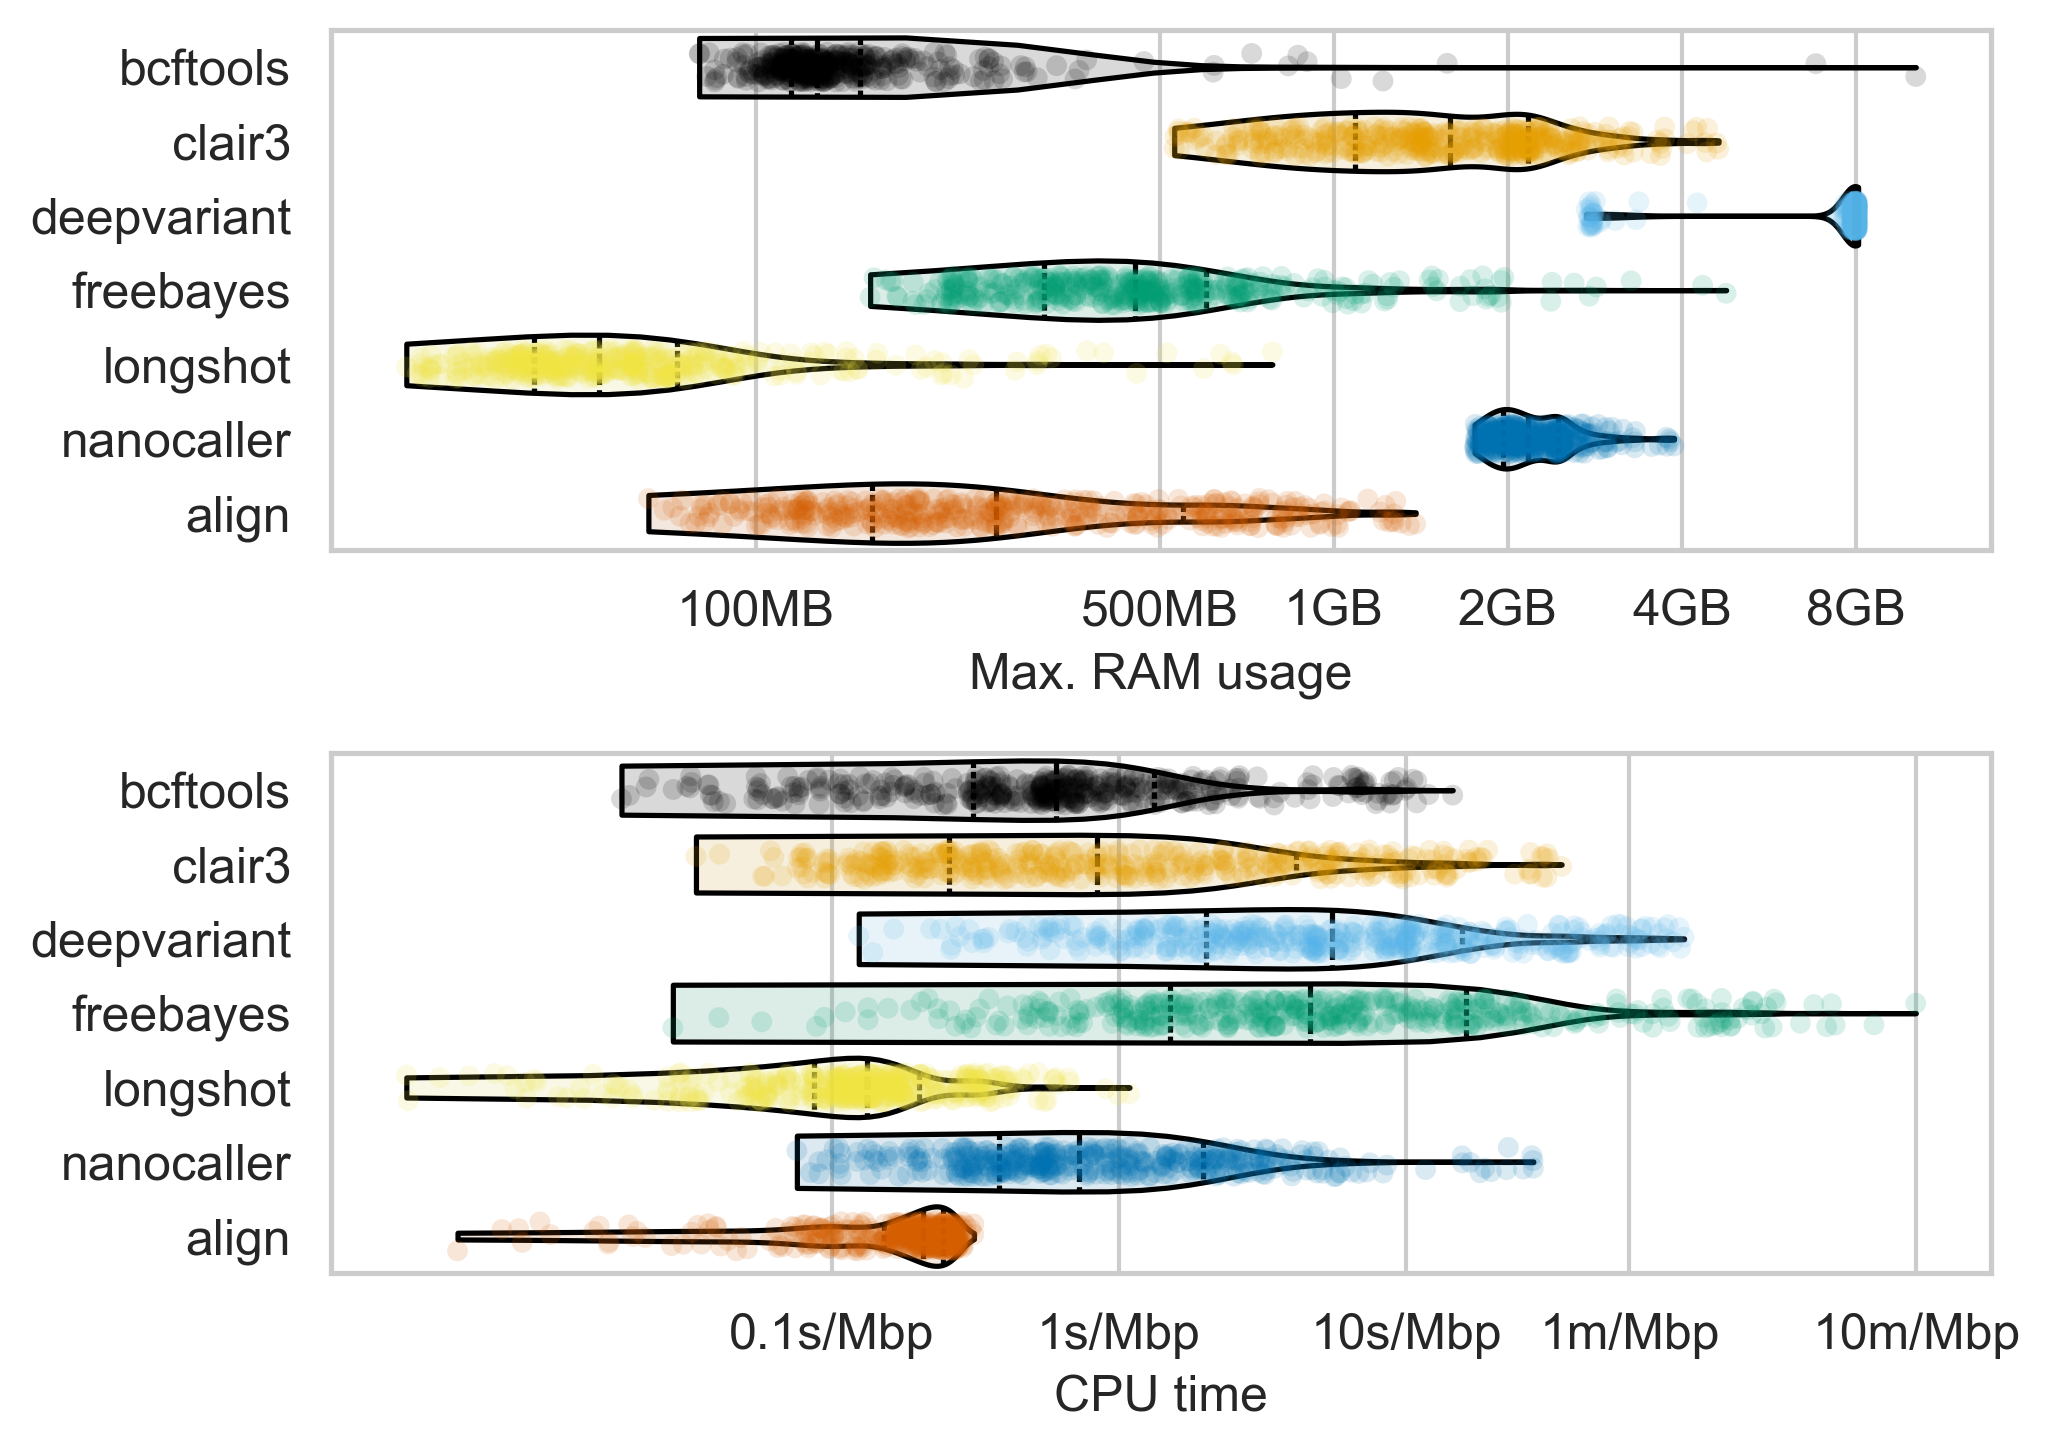

In [52]:
y = "caller"
hue = y
order = sorted(df[hue].unique())
# move longshot to the end
order.remove("align")
order.append("align")
palette = cud(n=len(df[hue].unique()))
fig, axes = plt.subplots(nrows=2, figsize=(7, 5), dpi=300, sharey=True)

# plot memory
x = "max_rss"
mem_ax = axes[0]
violin_alpha = 0.15
strip_alpha = 0.15
jitter = 0.2
orient = "h"

kwargs = dict(
    data=df,
    x=x,
    y=y,
    hue=hue,
    order=order,
    hue_order=order,
    palette=palette,
    orient=orient,
    dodge=False,
)
sns.violinplot(**kwargs, cut=0, inner="quartile", ax=mem_ax)
# sns.boxenplot(**kwargs, ax=mem_ax, fill=None, showfliers=False)
for violin in mem_ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(**kwargs, alpha=strip_alpha, edgecolor="auto", linewidth=0, ax=mem_ax, jitter=jitter)
mem_ax.set_xscale("log")
ticks = [
    (100, "100MB"),
    (500, "500MB"),
    (1000, "1GB"),
    (2000, "2GB"),
    # (3000, "3GB"),
    (4000, "4GB"),
    (8000, "8GB"),
]
FS = 12
mem_ax.set_xticks([t[0] for t in ticks])
mem_ax.set_xticklabels([t[1] for t in ticks], fontsize=FS)
mem_ax.set_xlabel("Max. RAM usage", fontsize=FS)
mem_ax.set_ylabel("")
mem_ax.tick_params(axis="both", which="major", labelsize=FS)

# plot time (rate)
x = "rate"
rt_ax = axes[1]
kwargs["x"] = x

# sns.boxenplot(**kwargs, ax=rt_ax, fill=None, showfliers=False)
sns.violinplot(**kwargs, cut=0, inner="quartile", ax=rt_ax)
for violin in rt_ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))

sns.stripplot(**kwargs, alpha=strip_alpha, edgecolor="auto", linewidth=0, ax=rt_ax, jitter=jitter)

rt_ax.set_xscale("log")
ticks = [
    (0.1, "0.1s/Mbp"),
    (1, "1s/Mbp"),
    (10, "10s/Mbp"),
    (60, "1m/Mbp"),
    (600, "10m/Mbp"),
]
rt_ax.set_xticks([t[0] for t in ticks])
rt_ax.set_xticklabels([t[1] for t in ticks], fontsize=FS)
rt_ax.set_xlabel("CPU time", fontsize=FS)
rt_ax.set_ylabel("")
rt_ax.tick_params(axis="both", which="major", labelsize=FS)
fig.tight_layout()

In [42]:
df.groupby([hue]).describe()

s                                                          \
             count        mean          std      min        25%        50%   
caller                                                                       
bcftools     420.0  239.940328   609.415608   3.6850  13.895400   31.40405   
clair3       420.0  122.344081   108.943906  25.5907  55.934225   79.43580   
deepvariant  420.0  359.735522   676.928218  34.6149  78.582375  130.31105   
freebayes    420.0  940.057159  3222.627496   2.2951  26.294400   80.95255   
longshot     420.0   22.867092    41.409982   1.5568   4.561150   10.58105   
nanocaller   420.0   48.006573    36.899241  11.0583  25.280625   36.28435   

                                    max_rss               ...           bp  \
                    75%         max   count         mean  ...          75%   
caller                                                    ...                
bcftools     164.820825   5791.8040   420.0   196.862762  ...  179337200.0   
clair3       148.771775    672.8684   420.0  1716.542310  ...  179337200.0   
deepvariant  260.313925   5424.2915   420.0  7620.116643  ...  179337200.0   
freebayes    388.278125  41997.7172   420.0   577.024810  ...  179337200.0   
longshot      24.352000    481.2831   420.0    77.403238  ...  179337200.0   
nanocaller    57.522075    283.9436   420.0  2244.631167  ...  179337200.0   

                           rate                                            \
                     max  count       mean        std       min       25%   
caller                                                                      
bcftools     566438200.0  420.0   1.435434   2.296589  0.018537  0.309924   
clair3       566438200.0  420.0   3.510626   5.969230  0.033685  0.257176   
deepvariant  566438200.0  420.0  13.640349  18.921000  0.124275  2.011872   
freebayes    566438200.0  420.0  24.410599  57.933888  0.027988  1.511177   
longshot     566438200.0  420.0   0.166836   0.138924  0.003301  0.086938   
nanocaller   566438200.0  420.0   1.916485   3.780517  0.075666  0.384028   

                                              
                  50%        75%         max  
caller                                        
bcftools     0.603386   1.324358   14.553632  
clair3       0.840295   4.130172   34.858726  
deepvariant  5.548641  15.621898   93.057864  
freebayes    4.622722  16.219342  596.692896  
longshot     0.133206   0.201111    1.089940  
nanocaller   0.725058   1.961123   27.781116  

[6 rows x 96 columns]

In [43]:
df

,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,sample,model,mode,depth,caller,bp,rate
0,27.2634,0:00:27,2430.59,12442.39,1239.43,1443.16,135.55,1.22,147.75,44.61,AMtb_1__202402,hac,duplex,10,nanocaller,44055370,1.012589
0,20.4283,0:00:20,1999.21,11778.52,819.17,1021.98,135.87,3.26,187.94,44.34,ATCC_19119__202309,hac,duplex,10,nanocaller,29192130,1.518903
0,22.5279,0:00:22,1991.00,11561.30,796.44,999.21,136.24,2.96,145.98,39.60,BPH2947__202310,hac,duplex,10,nanocaller,30799530,1.285734
0,29.9515,0:00:29,2424.36,12368.58,1235.61,1438.62,132.41,1.57,150.68,47.30,ATCC_10708__202309,hac,duplex,10,nanocaller,48019670,0.985013
0,31.6126,0:00:31,2485.42,12434.79,1221.24,1424.30,132.45,1.93,159.21,51.22,AJ292__202310,hac,duplex,10,nanocaller,54450050,0.940679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1670.1547,0:27:50,587.90,1620.15,541.79,546.42,0.00,61.66,402.30,6720.72,MMC234__202311,fast,simplex,25,freebayes,55123575,121.920975
0,1434.2448,0:23:54,693.06,1726.71,641.01,645.74,0.00,68.56,508.21,7290.91,ATCC_BAA-679__202309,fast,simplex,25,freebayes,73612725,99.044153
0,993.6241,0:16:33,446.85,1463.95,404.98,408.48,0.02,42.32,355.16,3530.28,RDH275__202311,fast,simplex,25,freebayes,44834300,78.740607
0,7806.0561,2:10:06,1923.74,2986.12,1778.84,1782.47,0.00,214.71,528.76,41358.47,KPC2__202310,fast,simplex,25,freebayes,141609550,292.059893


In [53]:
gpudf = pd.read_csv("gpu_runtime.tsv", sep="\t")

In [54]:
gpudf

,sample,model,replicate,bp,start_time,end_time,difference,difference_seconds,mbps,samples_per_second,run
0,MMC234__202311,hac,3,961144665,2024-03-13 00:43:20.082,2024-03-13 00:43:42.506,0 days 00:00:22.424000,22.424,42.862320,6.065229e+08,cuda:all
1,KPC2__202310,fast,1,423945966,2024-03-13 00:30:03.688,2024-03-13 00:30:12.995,0 days 00:00:09.307000,9.307,45.551302,5.821846e+08,cuda:all
2,AJ292__202310,sup,1,586691747,2024-03-12 14:50:16.796,2024-03-12 14:51:08.301,0 days 00:00:51.505000,51.505,11.390967,1.392858e+08,cuda:all
3,ATCC_35221__202309,fast,3,2851611281,2024-03-12 22:08:26.465,2024-03-12 22:09:03.818,0 days 00:00:37.353000,37.353,76.342229,1.023493e+09,cuda:all
4,ATCC_17802__202309,hac,3,7313238535,2024-03-12 18:13:39.494,2024-03-12 18:16:08.984,0 days 00:02:29.490000,149.490,48.921256,6.734121e+08,cuda:all
...,...,...,...,...,...,...,...,...,...,...,...
247,ATCC_19119__202309,hac,3,4861986029,2024-03-13 17:46:34.218,2024-03-13 17:57:40.206,0 days 00:11:05.988000,665.988,7.300411,9.558733e+07,cuda:single
248,ATCC_25922__202309,sup,3,10952783043,2024-03-14 00:33:41.217,2024-03-14 03:10:27.923,0 days 02:36:46.706000,9406.706,1.164359,1.547824e+07,cuda:single
249,ATCC_35221__202309,fast,1,2851611281,2024-03-13 17:07:23.002,2024-03-13 17:10:08.620,0 days 00:02:45.618000,165.618,17.218003,2.291969e+08,cuda:single
250,ATCC_35221__202309,hac,2,2859875129,2024-03-13 17:25:43.897,2024-03-13 17:32:17.398,0 days 00:06:33.501000,393.501,7.267771,9.631102e+07,cuda:single


In [66]:
# create a new column seconds per megabase
gpudf["sec_per_mb"] = gpudf["difference_seconds"] / (gpudf["bp"] / 1e6)

In [64]:
gpudf

,sample,model,replicate,bp,start_time,end_time,difference,difference_seconds,mbps,samples_per_second,run,sec
0,MMC234__202311,hac,3,961144665,2024-03-13 00:43:20.082,2024-03-13 00:43:42.506,0 days 00:00:22.424000,22.424,42.862320,6.065229e+08,cuda:all,22.424
1,KPC2__202310,fast,1,423945966,2024-03-13 00:30:03.688,2024-03-13 00:30:12.995,0 days 00:00:09.307000,9.307,45.551302,5.821846e+08,cuda:all,9.307
2,AJ292__202310,sup,1,586691747,2024-03-12 14:50:16.796,2024-03-12 14:51:08.301,0 days 00:00:51.505000,51.505,11.390967,1.392858e+08,cuda:all,51.505
3,ATCC_35221__202309,fast,3,2851611281,2024-03-12 22:08:26.465,2024-03-12 22:09:03.818,0 days 00:00:37.353000,37.353,76.342229,1.023493e+09,cuda:all,37.353
4,ATCC_17802__202309,hac,3,7313238535,2024-03-12 18:13:39.494,2024-03-12 18:16:08.984,0 days 00:02:29.490000,149.490,48.921256,6.734121e+08,cuda:all,149.490
...,...,...,...,...,...,...,...,...,...,...,...,...
247,ATCC_19119__202309,hac,3,4861986029,2024-03-13 17:46:34.218,2024-03-13 17:57:40.206,0 days 00:11:05.988000,665.988,7.300411,9.558733e+07,cuda:single,665.988
248,ATCC_25922__202309,sup,3,10952783043,2024-03-14 00:33:41.217,2024-03-14 03:10:27.923,0 days 02:36:46.706000,9406.706,1.164359,1.547824e+07,cuda:single,9406.706
249,ATCC_35221__202309,fast,1,2851611281,2024-03-13 17:07:23.002,2024-03-13 17:10:08.620,0 days 00:02:45.618000,165.618,17.218003,2.291969e+08,cuda:single,165.618
250,ATCC_35221__202309,hac,2,2859875129,2024-03-13 17:25:43.897,2024-03-13 17:32:17.398,0 days 00:06:33.501000,393.501,7.267771,9.631102e+07,cuda:single,393.501


In [87]:
gpudf["replicate"].max()

3

In [88]:
gpudf.to_csv("gpu_runtime.csv", index=False)

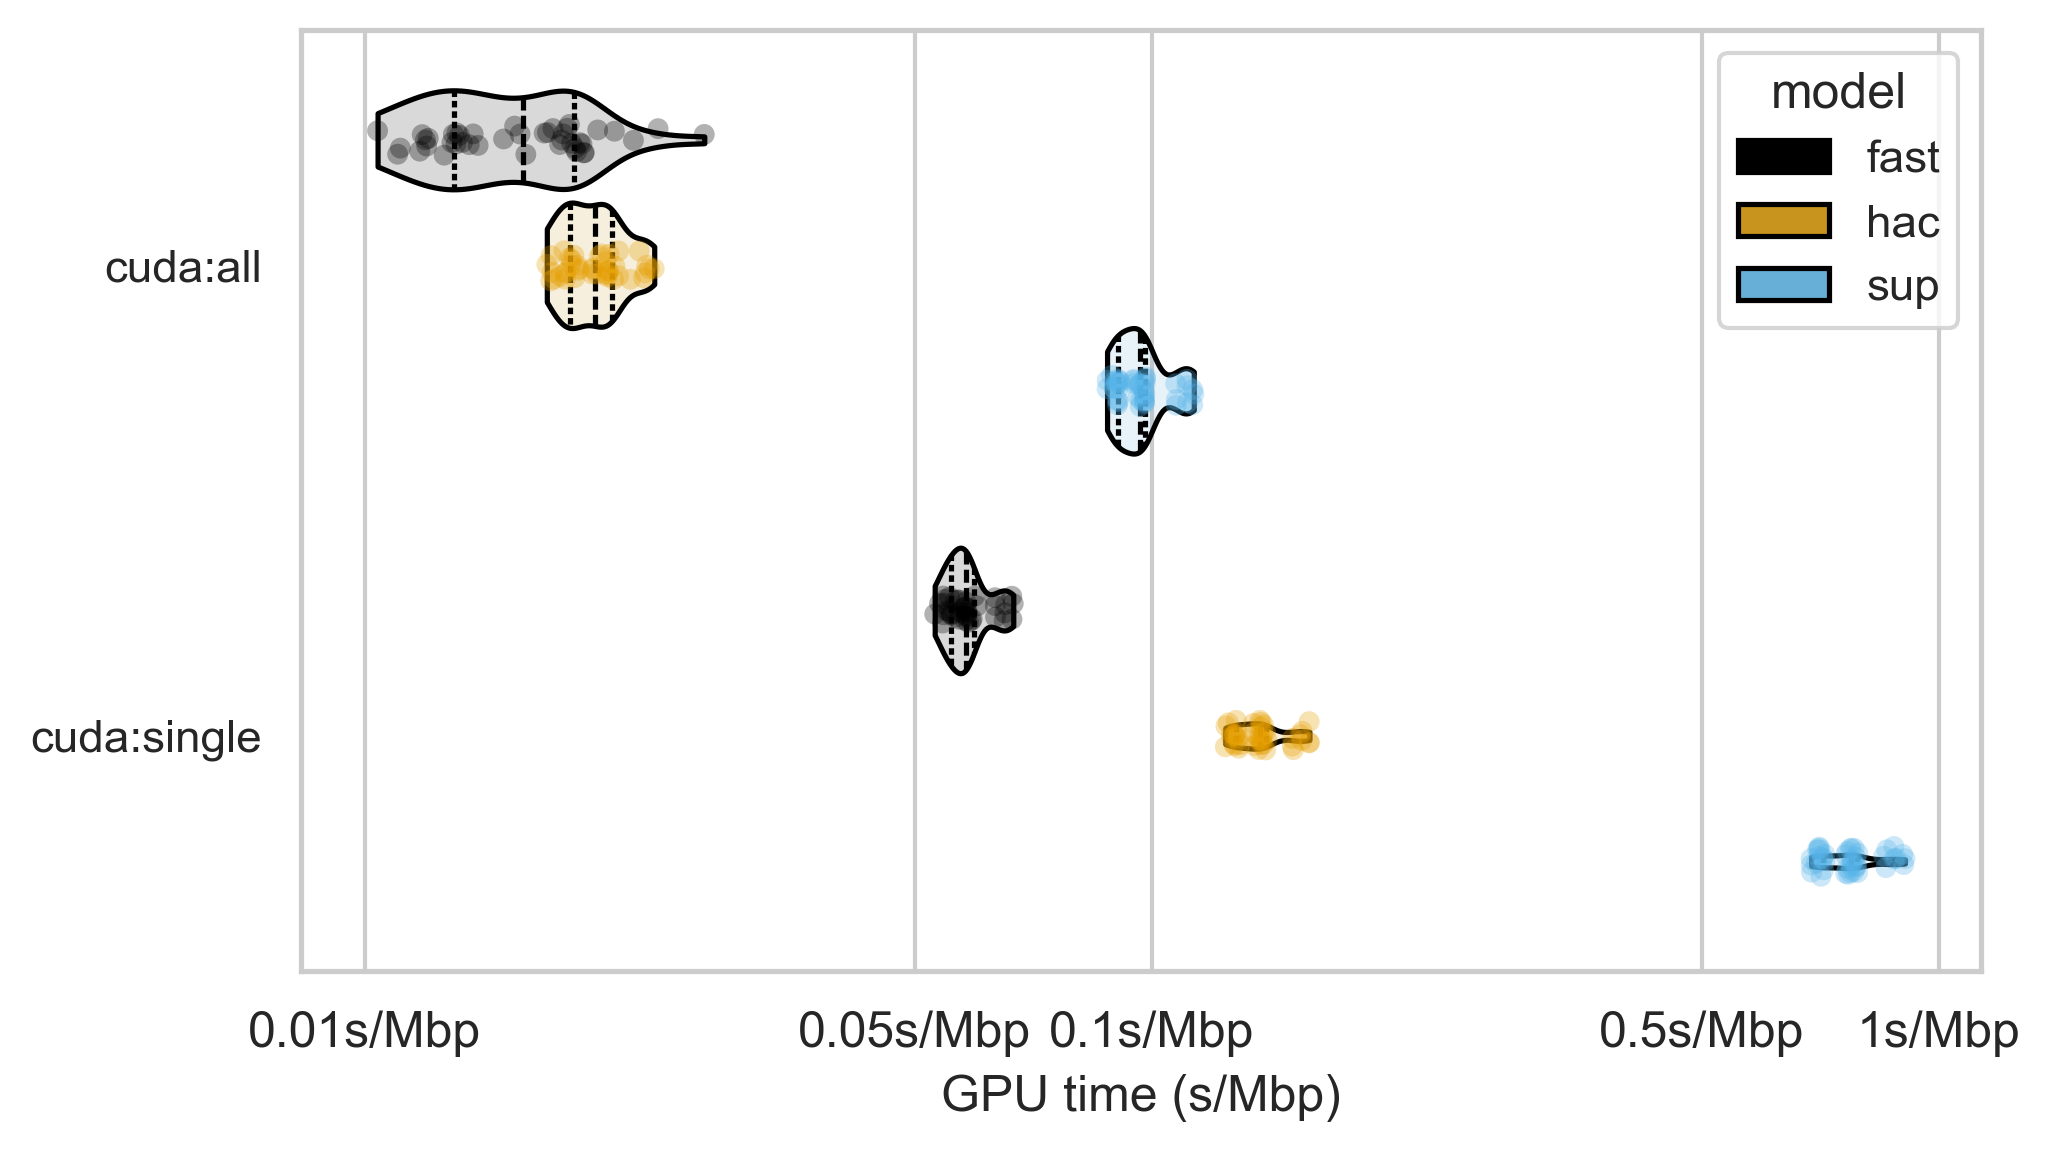

In [86]:
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4), dpi=300)

colors = cud(n=3)
x = "sec_per_mb"
y = "run"
hue = "model"
hue_order = ["fast", "hac", "sup"]

sns.violinplot(
    data=gpudf,
    x=x,
    y=y,
    hue=hue,
    hue_order=hue_order,
    ax=ax,
    legend=True,
    palette=colors,
    cut=0,
    inner="quartile",
)
for violin in ax.collections:
    violin.set_facecolor(to_rgba(violin.get_facecolor(), alpha=violin_alpha))
sns.stripplot(
    data=gpudf,
    x=x,
    y=y,
    hue=hue,
    hue_order=hue_order,
    ax=ax,
    dodge=True,
    legend=False,
    palette=colors,
    alpha=0.3,
)


ax.set_ylabel("")
ax.set_xscale("log")
ticks = [
    (0.01, "0.01s/Mbp"),
    (0.05, "0.05s/Mbp"),
    (0.1, "0.1s/Mbp"),
    (0.5, "0.5s/Mbp"),
    (1, "1s/Mbp"),
]
ax.set_xticks([t[0] for t in ticks])
ax.set_xticklabels([t[1] for t in ticks], fontsize=FS)
ax.set_xlabel("GPU time (s/Mbp)", fontsize=FS)


# Define custom legend
# legend_labels = ["fast", "hac", "sup"]
# colors = ["#000000", "#e69f00", "#56b4e9"]
# legend_handles = [
#     mpatches.Circle((0, 0), 1, color=color, label=label)
#     for label, color in zip(legend_labels, colors)
# ]

# Add the custom legend to the plot
# plt.legend(handles=legend_handles)

fig1.tight_layout()
fig1.savefig("gpu_runtime.pdf")#, dpi=300, transparent=False)